Skipped: images/12.jpg (not a valid image or corrupted)
Skipped: images/3d-cartoon-delivery-driver.jpg (not a valid image or corrupted)
Skipped: images/abstract-design-background-smooth-flowing-lines_1048-14640.avif (not a valid image or corrupted)
Skipped: images/abstract-multi-colored-illustration-nature-vibrant-beauty-generated-by-ai_188544-15591.avif (not a valid image or corrupted)
Skipped: images/colorful-flowers-leaves-dark-background-generative-ai_946522-16374.avif (not a valid image or corrupted)
Skipped: images/explosive-crazy-abstraction-bright-saturated-watercolor-colors-dark-background_465502-2104.avif (not a valid image or corrupted)
Error processing images/png-transparent-spider-man-heroes-download-with-transparent-background-free-thumbnail.png: cannot write mode P as JPEG


,File Name,Color Model,Format,Number of Channels,File Size (MB),Width,Height,Full Path,Resized Image
0,073ef6468773950fead6db04248425d7.png,RGBA,PNG,4,0.03,2560,1600,/drive/notebooks/images/073ef6468773950fead6db04248425d7.png,
1,09QpIkbEsTMSd.jpg!w700wp,RGB,WEBP,3,0.07,700,414,/drive/notebooks/images/09QpIkbEsTMSd.jpg!w700wp,
2,39PpIkbEsT4XC.jpg!w700wp,RGB,WEBP,3,0.04,700,414,/drive/notebooks/images/39PpIkbEsT4XC.jpg!w700wp,
3,3d-abstract-qi0b0ijfayv4d8ru.jpg,RGB,JPEG,3,0.05,900,563,/drive/notebooks/images/3d-abstract-qi0b0ijfayv4d8ru.jpg,
4,438463.png,RGBA,PNG,4,0.33,1920,1080,/drive/notebooks/images/438463.png,
5,8588d4433bb98ac16daaa294cd54246c.jpg,RGB,JPEG,3,0.15,720,1280,/drive/notebooks/images/8588d4433bb98ac16daaa294cd54246c.jpg,
6,b7a19241551c95a9848feb057e93b730.jpg,RGB,JPEG,3,0.06,735,752,/drive/notebooks/images/b7a19241551c95a9848feb057e93b730.jpg,
7,e36e163adaba71d5a6441ec0499829e1.png,RGBA,PNG,4,0.06,2560,1600,/drive/notebooks/images/e36e163adaba71d5a6441ec0499829e1.png,
8,f79ba9aa6a88039d981232bbc1e46e92.png,RGBA,PNG,4,0.02,2560,1600,/drive/notebooks/images/f79ba9aa6a88039d981232bbc1e46e92.png,
9,images (1).jpeg,RGB,JPEG,3,0.00,284,177,/drive/notebooks/images/images (1).jpeg,

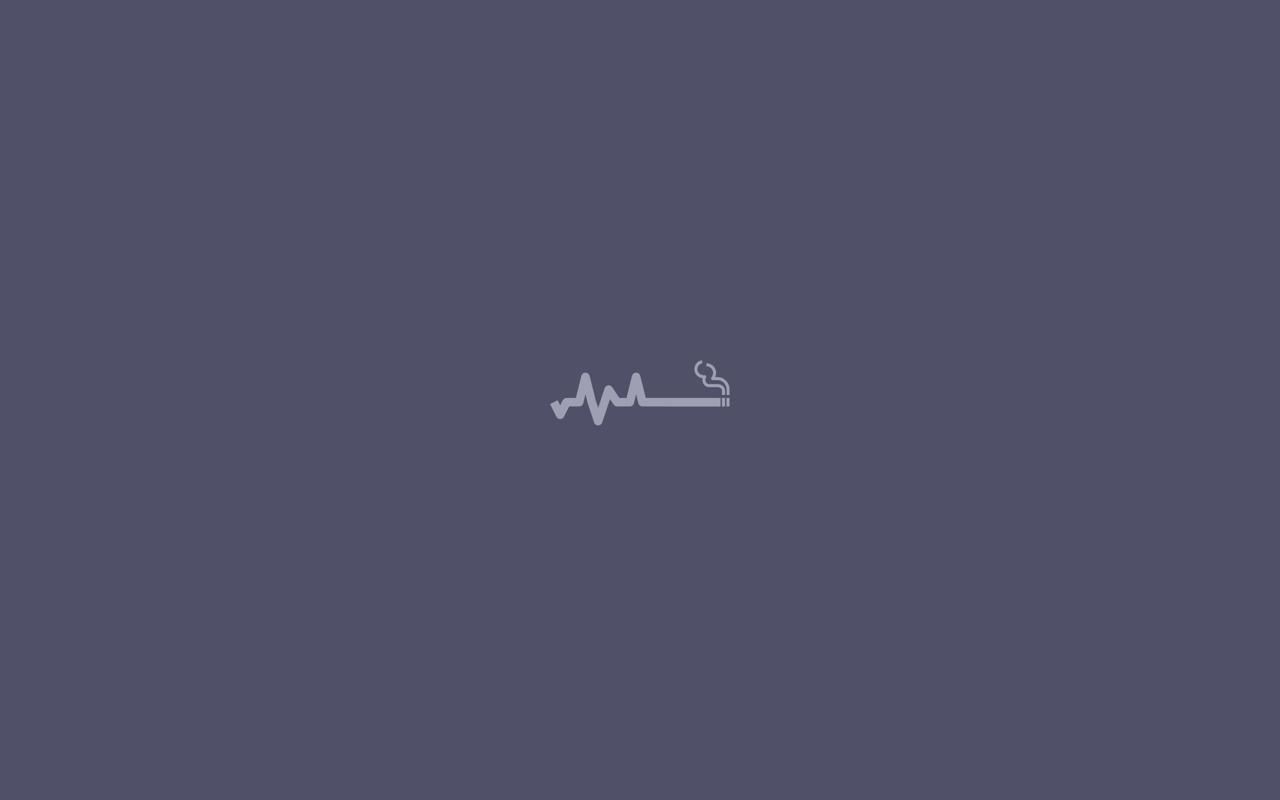
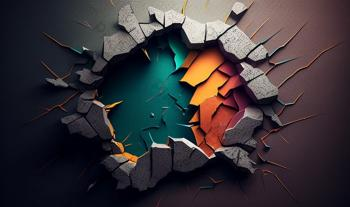
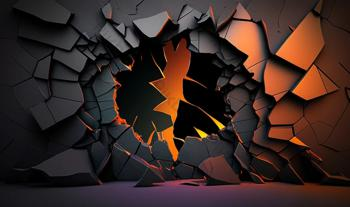
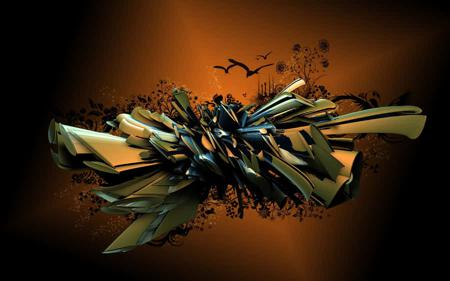
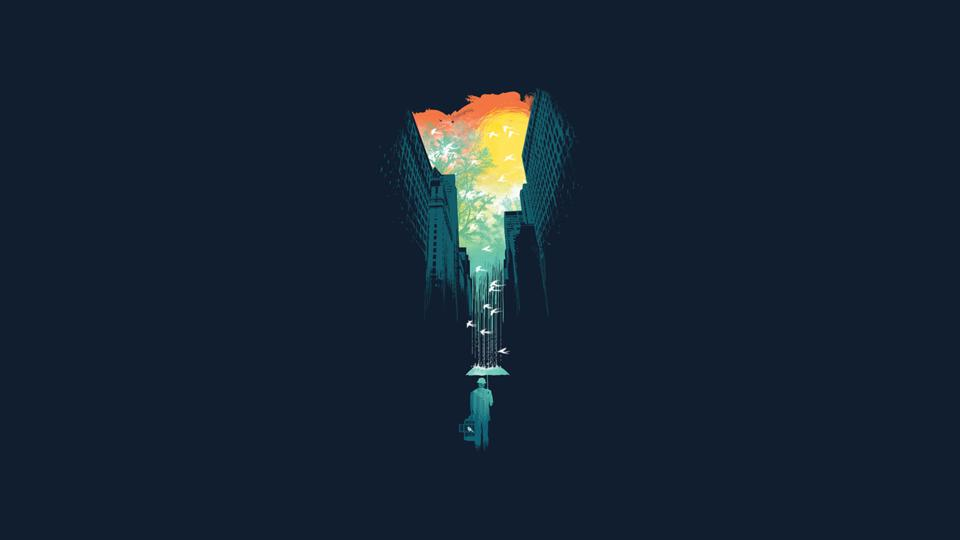
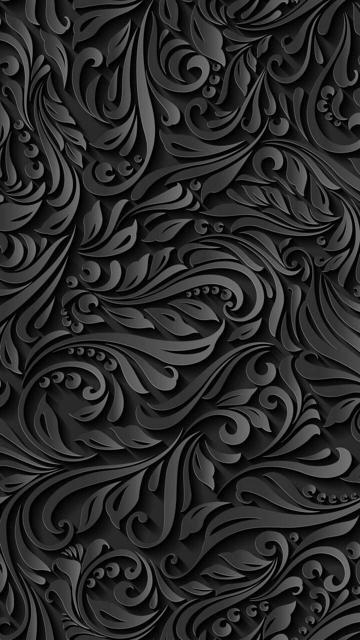
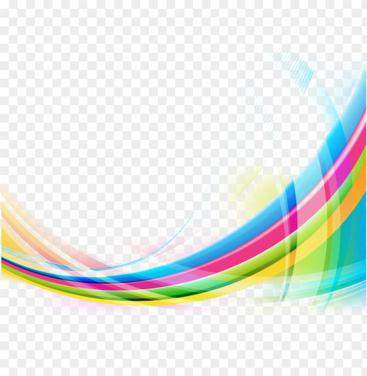
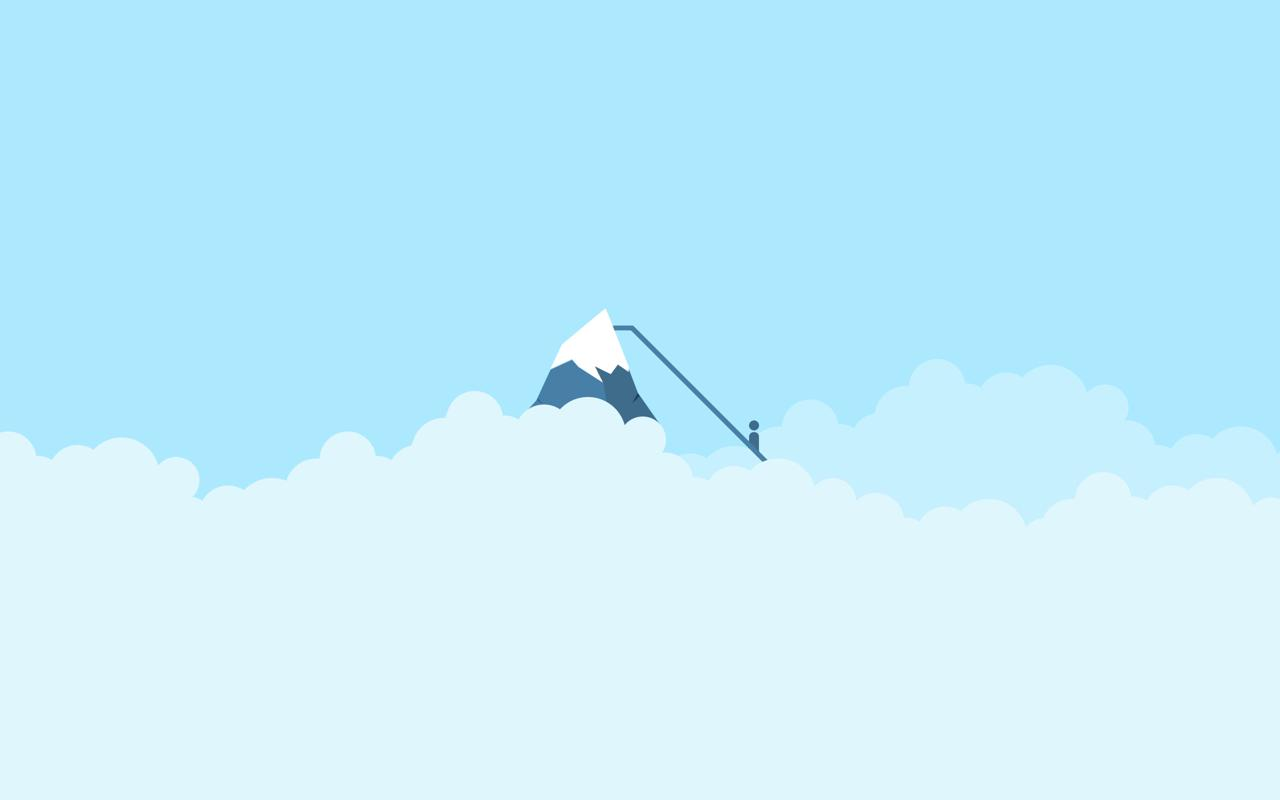
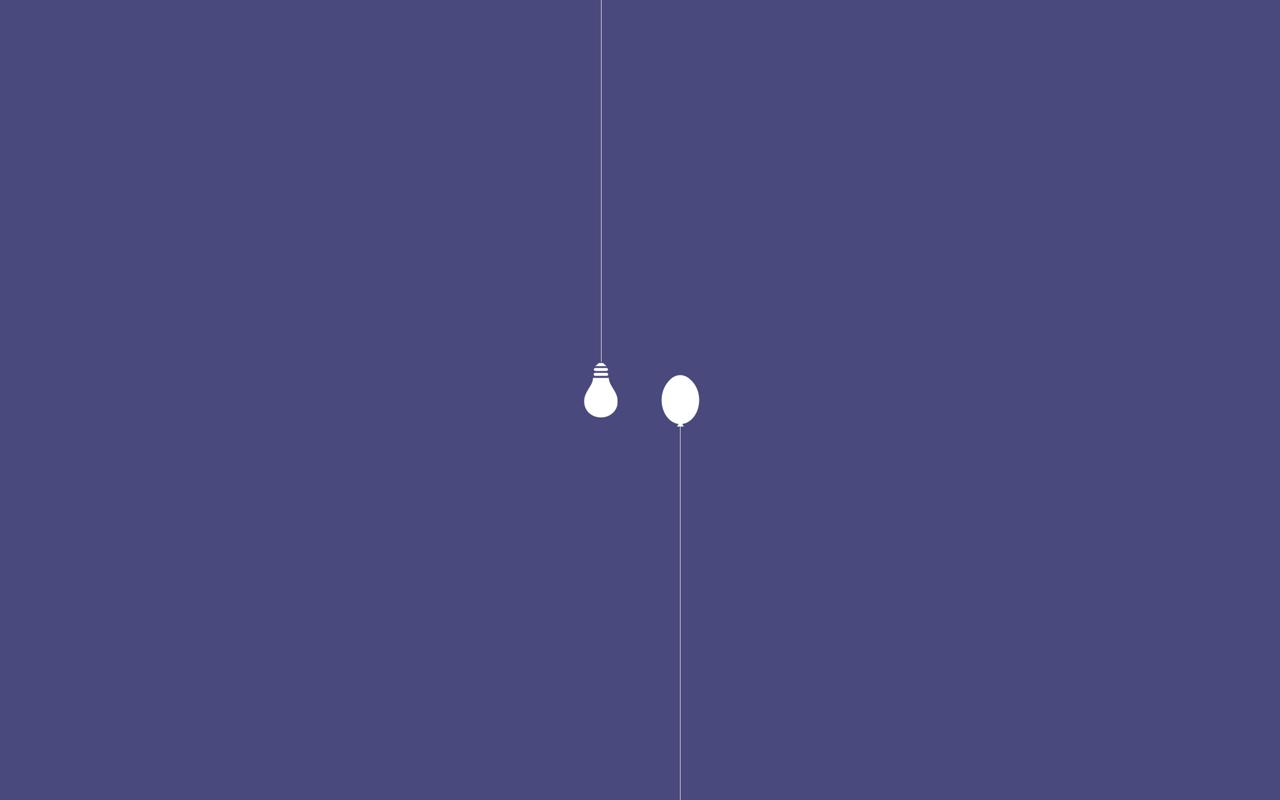
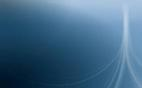
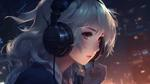
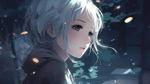
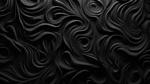
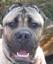
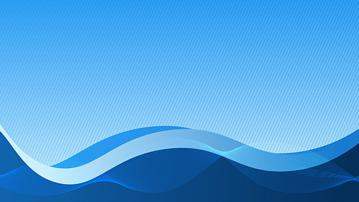
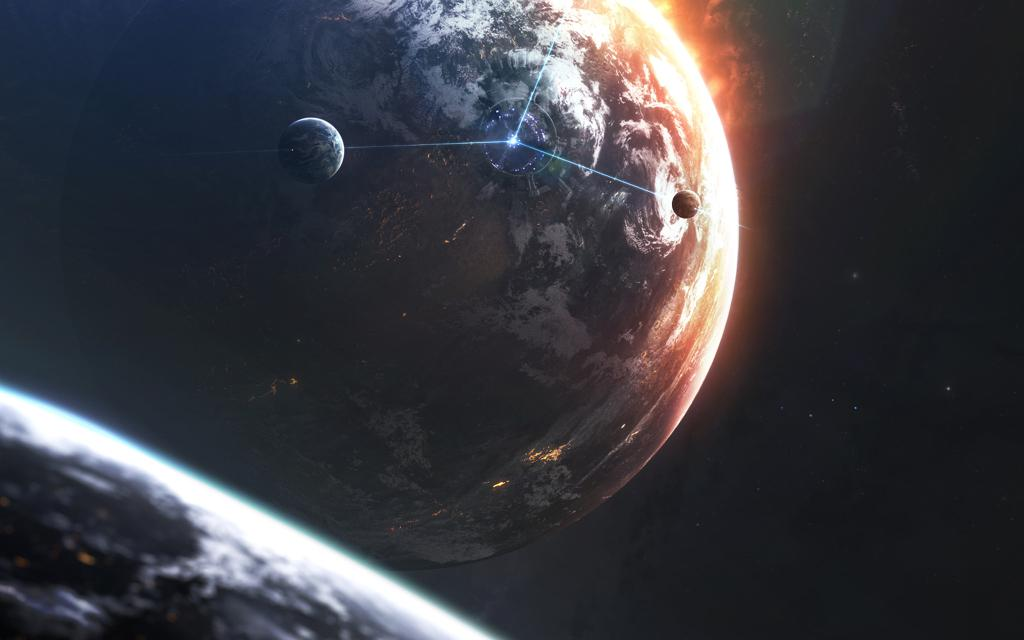

In [18]:
import os
import glob
import pandas as pd
from PIL import Image, UnidentifiedImageError
import base64
from io import BytesIO
from IPython.display import HTML

def get_image_info(folder_path):
    """
    Analyzes image files in the provided folder and returns their properties in a DataFrame.
    """
    # Get all files in the folder
    image_files = glob.glob(os.path.join(folder_path, "*"))
    
    # List to store image information
    image_data = []

    for image_file in image_files:
        try:
            # Open image to verify and extract its properties
            img = Image.open(image_file)
            img.verify()  # Validate if it's an actual image file

            # Reopen image (necessary after calling `verify()`)
            img = Image.open(image_file)
            
            # Extract image properties
            file_name = os.path.basename(image_file)
            color_model = img.mode
            format = img.format
            num_channels = len(img.getbands())
            file_size = round(os.path.getsize(image_file) / (1024 * 1024), 2)
            width, height = img.size
            full_path = os.path.abspath(image_file)
            
            # Resize image for display
            img_resized = img.resize((width // 2, height // 2))

            # Ensure proper color mode for display (convert to RGB if necessary)
            if img_resized.mode == 'RGBA':
                img_resized = img_resized.convert('RGB')

            # Encode the resized image to Base64
            buffered = BytesIO()
            img_resized.save(buffered, format="JPEG")  # Save as JPEG for consistent display
            img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
            img_data_uri = f"data:image/jpeg;base64,{img_base64}"

            # Append image properties to the data list
            image_data.append([
                file_name,
                color_model,
                format,
                num_channels,
                file_size,
                width,
                height,
                full_path,
                img_data_uri
            ])

        except UnidentifiedImageError:
            print(f"Skipped: {image_file} (not a valid image or corrupted)")
            continue
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
            continue
    
    # Create a DataFrame from the collected data
    df = pd.DataFrame(image_data, columns=[
        "File Name",
        "Color Model",
        "Format",
        "Number of Channels",
        "File Size (MB)",
        "Width",
        "Height",
        "Full Path",
        "Resized Image"
    ])
    
    return df

def image_formatter(value):
    """
    Formatter function to embed Base64 images into the DataFrame for display.
    """
    return f'<img src="{value}" width="100" />'

# Path to the folder containing images
folder_path = "images"

# Get image information and create a DataFrame
image_df = get_image_info(folder_path)

# Display the DataFrame with images using HTML
HTML(image_df.to_html(formatters={'Resized Image': image_formatter}, escape=False))


In [23]:
import os
import random
from PIL import Image, ImageEnhance, ImageOps, UnidentifiedImageError
from typing import Tuple

def apply_random_filter(image: Image.Image) -> Image.Image:
    """
    Apply a random color filter to the image.
    Filters include red, green, blue, yellow, purple, and cyan.
    """
    filters = {
        "red": (255, 0, 0),
        "green": (0, 255, 0),
        "blue": (0, 0, 255),
        "yellow": (255, 255, 0),
        "purple": (128, 0, 128),
        "cyan": (0, 255, 255)
    }
    filter_name = random.choice(list(filters.keys()))
    color_filter = filters[filter_name]
    
    # Create a color overlay
    overlay = Image.new("RGB", image.size, color_filter)
    blended = Image.blend(image.convert("RGB"), overlay, alpha=0.3)  # Apply filter with 30% strength
    return blended

def crop_to_square(image: Image.Image) -> Image.Image:
    """
    Crop the image to a square, centering on the middle of the image.
    """
    width, height = image.size
    min_side = min(width, height)
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return image.crop((left, top, right, bottom))

def create_poster(
    folder_path: str,
    output_name: str,
    cols: int,
    rows: int,
    image_size: Tuple[int, int] = (500, 500)
):
    """
    Create a poster by arranging images in a grid (cols x rows) with random filters applied.
    """
    # Get all image files from the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]

    if not image_files:
        raise ValueError("No valid images found in the specified folder.")
    
    # Prepare a blank canvas for the poster
    poster_width = cols * image_size[0]
    poster_height = rows * image_size[1]
    poster = Image.new("RGB", (poster_width, poster_height), color=(255, 255, 255))
    
    # Randomly pick and process images to fill the grid
    processed_images = 0
    for row in range(rows):
        for col in range(cols):
            # Ensure we have enough valid images to process
            if not image_files:
                print("Not enough valid images to complete the poster.")
                return
            
            # Randomly choose an image and process it
            try:
                random_image_path = random.choice(image_files)
                img = Image.open(random_image_path)
                img = crop_to_square(img)
                img = img.resize(image_size)
                img = apply_random_filter(img)
                
                # Paste the processed image onto the poster
                x = col * image_size[0]
                y = row * image_size[1]
                poster.paste(img, (x, y))
                processed_images += 1
            except (UnidentifiedImageError, OSError):
                print(f"Skipping invalid or corrupted image: {random_image_path}")
                image_files.remove(random_image_path)  # Remove problematic file from the list
            except Exception as e:
                print(f"An unexpected error occurred: {e}")
                continue
    
    if processed_images > 0:
        # Save the poster
        poster.save(output_name)
        print(f"Poster saved as: {output_name}")
    else:
        print("No valid images were processed to create the poster.")

def generate_posters(folder_path: str, cols: int, rows: int, num_variants: int = 4):
    """
    Generate multiple poster variants and save them to disk.
    """
    for i in range(num_variants):
        output_name = f"poster_variant_{i + 1}.jpg"
        create_poster(folder_path, output_name, cols, rows)

# Example Usage
folder_path = "images"  # Path to the folder with images
cols = 3  # Number of images per row
rows = 4  # Number of images per column

generate_posters(folder_path, cols, rows)


Skipping invalid or corrupted image: images/12.jpg
Poster saved as: poster_variant_1.jpg
Poster saved as: poster_variant_2.jpg
Poster saved as: poster_variant_3.jpg
Poster saved as: poster_variant_4.jpg
